In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install timm torchmetrics grad-cam &> /dev/null

In [2]:
import os
import sys
import shutil
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

import timm

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
import torch.optim as optim

from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinarySpecificity

from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedGroupKFold


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
from sklearn.metrics import *
from collections import Counter
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
#import preprocessing
from tqdm import tqdm
from io import BytesIO
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from sklearn.utils import compute_class_weight
from sklearn.model_selection import *
# import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings('ignore')
print("All modules have been imported")

2023-03-19 17:28:48.876901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 17:28:48.970822: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-19 17:28:49.672295: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /media/rohit/mirlproject2/rsna-breast-cancer-detection/rsna/lib/python3.8/site-packages

All modules have been imported


In [4]:
train_df = pd.read_csv('/media/rohit/mirlproject2/rsna-breast-cancer-detection/train.csv')

In [5]:
ddsm = train_df[['patient_id', 'image_id', 'cancer']]

In [6]:
img_folder= './archive/bc_1280_train_lut/'
ddsm['img_path_list'] = ddsm.apply(lambda x: img_folder+str(x.patient_id)+'_'+str(x.image_id)+'.png', axis = 1)

ddsm.tail(15)

patient_id    image_id  cancer  \
54691        9968  2098937312       0   
54692        9968   294168046       0   
54693        9968   568005453       0   
54694         997   873425464       0   
54695         997  2129119612       0   
54696         997  1487679918       0   
54697         997  1775983513       0   
54698        9973  1345265157       0   
54699        9973  1703611570       0   
54700        9973   655941939       0   
54701        9973  1729524723       0   
54702        9989    63473691       0   
54703        9989  1078943060       0   
54704        9989   398038886       0   
54705        9989   439796429       0   

                                         img_path_list  
54691  ./archive/bc_1280_train_lut/9968_2098937312.png  
54692   ./archive/bc_1280_train_lut/9968_294168046.png  
54693   ./archive/bc_1280_train_lut/9968_568005453.png  
54694    ./archive/bc_1280_train_lut/997_873425464.png  
54695   ./archive/bc_1280_train_lut/997_2129119612.png  
54696   ./archive/bc_1280_train_lut/997_1487679918.png  
54697   ./archive/bc_1280_train_lut/997_1775983513.png  
54698  ./archive/bc_1280_train_lut/9973_1345265157.png  
54699  ./archive/bc_1280_train_lut/9973_1703611570.png  
54700   ./archive/bc_1280_train_lut/9973_655941939.png  
54701  ./archive/bc_1280_train_lut/9973_1729524723.png  
54702    ./archive/bc_1280_train_lut/9989_63473691.png  
54703  ./archive/bc_1280_train_lut/9989_1078943060.png  
54704   ./archive/bc_1280_train_lut/9989_398038886.png  
54705   ./archive/bc_1280_train_lut/9989_439796429.png

In [7]:
# g = ddsm[:54705]

In [8]:
# g.tail(15)

In [9]:
print(ddsm.iloc[0])
ddsm.iloc[0]['img_path_list']

patient_id                                                 10006
image_id                                               462822612
cancer                                                         0
img_path_list    ./archive/bc_1280_train_lut/10006_462822612.png
Name: 0, dtype: object


'./archive/bc_1280_train_lut/10006_462822612.png'

In [10]:
from PIL import Image

img = Image.open(ddsm.iloc[17]['img_path_list'])
img=transforms.ToTensor()(img)
img.shape

torch.Size([1, 1280, 774])

In [11]:
images_list = ddsm['img_path_list']

In [12]:
images_list=list(images_list)

In [13]:
len(images_list)

54706

In [14]:
ddsm.sort_values('cancer', inplace =True)
ddsm

patient_id    image_id  cancer  \
0           10006   462822612       0   
36258       48921  1920949802       0   
36259       48939   105720752       0   
36260       48939   441053398       0   
36263        4894   368240487       0   
...           ...         ...     ...   
17738       28747  1026238054       1   
17739       28747  2075658562       1   
29638       41610  1957729736       1   
8602        19182  1872087937       1   
52732        7780   512684699       1   

                                          img_path_list  
0       ./archive/bc_1280_train_lut/10006_462822612.png  
36258  ./archive/bc_1280_train_lut/48921_1920949802.png  
36259   ./archive/bc_1280_train_lut/48939_105720752.png  
36260   ./archive/bc_1280_train_lut/48939_441053398.png  
36263    ./archive/bc_1280_train_lut/4894_368240487.png  
...                                                 ...  
17738  ./archive/bc_1280_train_lut/28747_1026238054.png  
17739  ./archive/bc_1280_train_lut/28747_2075658562.png  
29638  ./archive/bc_1280_train_lut/41610_1957729736.png  
8602   ./archive/bc_1280_train_lut/19182_1872087937.png  
52732    ./archive/bc_1280_train_lut/7780_512684699.png  

[54706 rows x 4 columns]

In [15]:
ddsm['cancer'].sum()

1158

In [16]:
h = ddsm.iloc[54706-2316:]
h

patient_id    image_id  cancer  \
17757       28766  1237905181       0   
17758       28766  1788400148       0   
17759       28766  1110412361       0   
17760       28766  1761592877       0   
17761       28768   724520365       0   
...           ...         ...     ...   
17738       28747  1026238054       1   
17739       28747  2075658562       1   
29638       41610  1957729736       1   
8602        19182  1872087937       1   
52732        7780   512684699       1   

                                          img_path_list  
17757  ./archive/bc_1280_train_lut/28766_1237905181.png  
17758  ./archive/bc_1280_train_lut/28766_1788400148.png  
17759  ./archive/bc_1280_train_lut/28766_1110412361.png  
17760  ./archive/bc_1280_train_lut/28766_1761592877.png  
17761   ./archive/bc_1280_train_lut/28768_724520365.png  
...                                                 ...  
17738  ./archive/bc_1280_train_lut/28747_1026238054.png  
17739  ./archive/bc_1280_train_lut/28747_2075658562.png  
29638  ./archive/bc_1280_train_lut/41610_1957729736.png  
8602   ./archive/bc_1280_train_lut/19182_1872087937.png  
52732    ./archive/bc_1280_train_lut/7780_512684699.png  

[2316 rows x 4 columns]

In [17]:
class DDSMDataset(Dataset):
    def __init__(self, df, is_test=False, transform=None):

        self.images_list = df['img_path_list']
        self.images_list = list(self.images_list)
        self.labels_list = df['cancer']
        self.labels_list = list(self.labels_list)
        
        self.is_test = is_test
        self.transform = transform
        
    def __len__(self):
        return len(self.labels_list)
    
    def __getitem__(self, idx):
        if self.is_test:
            img = Image.open(self.images_list[idx])
            
        else:
            img = Image.open(self.images_list[idx])
        img = transforms.ToTensor()(img)
        if self.transform is not None:
            img = self.transform(img)
        #img = torch.permute(img, (2, 0, 1)) 
        img = transforms.Resize((512,512))(img)  
        img = img.repeat(3,1,1)
        if not self.is_test:
            target = self.labels_list[idx]
            return img, target
        #img = img.unsqueeze(0)
        
        return img, target

In [18]:
train_dataset = DDSMDataset(ddsm, is_test=False, transform=None)
# valid_dataset = DDSMDataset(images_list = x_val, labels_list = y_val, is_test=False, transform=None)
# test_dataset = DDSMDataset(images_list = x_test, labels_list = y_test, is_test=False, transform=None)
    
#train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
len(train_dataset)

54706

In [19]:
np.unique(ddsm['cancer'])

array([0, 1])

In [20]:
class_weights = []
for i in np.unique(ddsm['cancer']):
    class_weights.append(1/len(ddsm[ddsm['cancer']==i]))
class_weights

[1.8674833793979235e-05, 0.0008635578583765112]

In [21]:
train_dataset[-1]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.6456, 0.6840, 0.6866],
          [0.0000, 0.0000, 0.0000,  ..., 0.6957, 0.6816, 0.7270],
          [0.0000, 0.0000, 0.0000,  ..., 0.6824, 0.7318, 0.6877],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.6456, 0.6840, 0.6866],
          [0.0000, 0.0000, 0.0000,  ..., 0.6957, 0.6816, 0.7270],
          [0.0000, 0.0000, 0.0000,  ..., 0.6824, 0.7318, 0.6877],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.6456, 0.6840, 0.6866],
          [0.0000, 0.0000, 0.0000,  ..., 0.6957, 0.6816, 0.7270],
          [0.0000, 0.0000, 0.0000,  ...,

In [22]:
(train_dataset[11][0].shape)

torch.Size([3, 512, 512])

In [23]:
type(train_dataset)

__main__.DDSMDataset

In [24]:
import collections
from tqdm.notebook import tqdm_notebook

# get labels
# for _,y in tqdm()
y_train=[y for _,y in tqdm(train_dataset)]

# count labels
counter_train=collections.Counter(y_train)
print(counter_train)

100%|██████████| 54706/54706 [17:09<00:00, 53.13it/s]

Counter({0: 53548, 1: 1158})


In [25]:
# count_1=0
# count_0=0
# for _,y in tqdm_notebook(train_dataset):
#     if y==1:
#         count_1+=1
#     else:
#         count_0+=1

In [26]:
# count_1

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=list(range(len(train_dataset)))
#y_train0=[y for _,y in train_dataset]
for train_index, val_index in sss.split(indices, y_train):
    print("train:", train_index, "val:", val_index)
    print(len(train_index),len(val_index))

train: [18750 54408 10280 ... 31797 28183 51946] val: [31739 48410  3463 ...  3869  5534  6879]
43764 10942


In [28]:
from torch.utils.data import Subset

train_ds=Subset(train_dataset,train_index)
val_data=Subset(train_dataset,val_index)

In [29]:
print(len(train_ds))
print(len(val_data))

43764
10942


In [30]:
# y_train_ds=[y for _,y in tqdm_notebook(train_ds)]

# # count labels
# counter_train=collections.Counter(y_train_ds)
# print(counter_train)

In [31]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

indices=list(range(len(val_data)))
y_val=[y for _,y in tqdm(val_data)]
for val_index, test_index in sss.split(indices, y_val):
    print("val:", val_index, "val:", test_index)
    print(len(val_index),len(test_index))

100%|██████████| 10942/10942 [01:41<00:00, 108.05it/s]

val: [4240 8240 9346 ... 3915 8934 8082] val: [6052  119 9137 ... 5464  585 6975]
9847 1095


In [32]:
val_ds=Subset(val_data,val_index)
test_ds=Subset(val_data,test_index)

In [33]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

43764
9847
1095


In [34]:
# y_test=[y for _,y in test_ds]
# y_val=[y for _,y in val_ds]

# counter_test=collections.Counter(y_test)
# counter_val=collections.Counter(y_val)
# print(counter_test)
# print(counter_val)

image indices: [ 2732 43567 42613 21243]


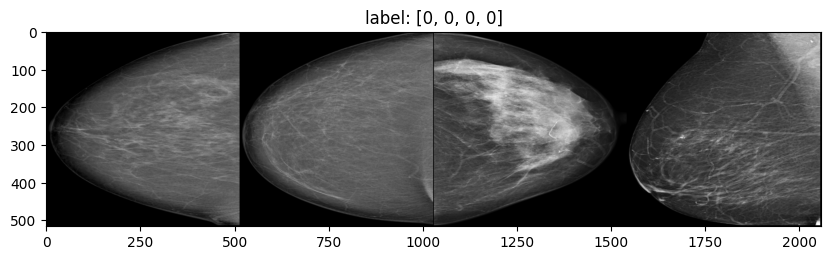

In [35]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
#print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

image indices: [2732 9845 3264 4859]


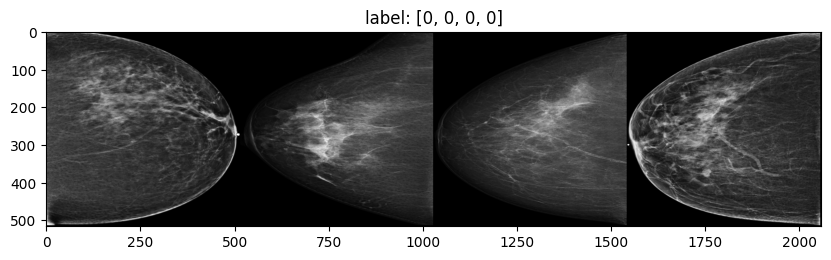

In [36]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[val_ds[i][0] for i in rnd_inds]
y_grid=[val_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
#print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

image indices: [684 559 835 763]


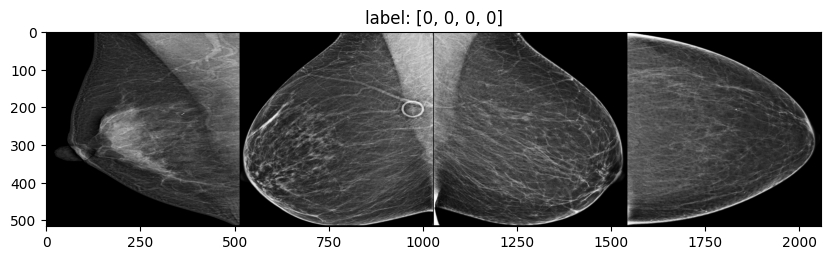

In [37]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(test_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[test_ds[i][0] for i in rnd_inds]
y_grid=[test_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
#print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

In [38]:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
    transforms.Normalize((0.5,), (0.5,))])
                 

test0_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
    transforms.Normalize((0.5,), (0.5,)),
    ])

In [39]:
train_ds.transform=train_transformer
val_data.transform=test0_transformer

In [40]:
sample_weights = [0]*len(train_ds)
for idx, (data, label) in enumerate(train_ds):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

In [41]:
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [42]:
train_dl1 = DataLoader(train_ds, batch_size=4, shuffle=True)
for i, (x,y) in enumerate(train_dl1):
    print(y.sum())
    if i>20:
        break

tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)


In [43]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=4, sampler=sampler)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False) 

In [44]:
# for idx, tensor in enumerate(train_dl):
#     torch.save(tensor, f"dataloaders/traindl/tensor{idx}.pt")


In [45]:
# for idx, tensor in enumerate(val_dl):
#     torch.save(tensor, f"dataloaders/valdl/tensor{idx}.pt")

In [46]:
# class FolderDataset(Dataset):
#    def __init__(self, folder):
#        self.files = os.listdir(folder)
#        self.folder = folder
#    def __len__(self):
#        return len(self.files)
#    def __getitem__(self, idx):
#        return torch.load(f"{self.folder}/{self.files[idx]}")

In [47]:
for i, (x,y) in enumerate(train_dl):
    print(y.sum())
    if i>20:
        break

tensor(2)
tensor(1)
tensor(2)
tensor(3)
tensor(2)
tensor(1)
tensor(1)
tensor(1)
tensor(3)
tensor(2)
tensor(3)
tensor(2)
tensor(1)
tensor(1)
tensor(1)
tensor(2)
tensor(3)
tensor(1)
tensor(2)
tensor(1)
tensor(1)
tensor(1)


In [48]:
for x, y in train_dl1:
    print(x.shape)
    print(y.shape)
    break

torch.Size([4, 3, 512, 512])
torch.Size([4])


In [49]:
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([16, 3, 512, 512])
torch.Size([16])


In [50]:
from torchvision import models
import torch
from torch import nn

# load model with pretrained weights
#model = torch.hub.load('hankyul2/EfficientNetV2-pytorch', 'efficientnet_v2_l', pretrained=True, nclass=2)

efficientnet_b7_pretrained = models.efficientnet_b7(pretrained=True)


In [51]:
efficientnet_b7_pretrained

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [52]:
# densenet121_pretrained.features.conv0


In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# densenet121_pretrained.features.conv0=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
efficientnet_b7_pretrained.classifier=nn.Sequential(nn.Dropout(p=0.5, inplace=True),
                                                    nn.Linear(2560,2))
efficientnet_b7_pretrained = efficientnet_b7_pretrained.to(device)

In [54]:
#densenet121_pretrained.load_state_dict(torch.load('./densenet121_pretrained_abhishek_expt1 (copy).pt', map_location =torch.device('cuda')))

In [55]:
efficientnet_b7_pretrained

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [56]:
for x,y in train_dl:
    print(x.shape)
    break
  
efficientnet_b7_pretrained(x.cuda()).shape

torch.Size([4, 3, 512, 512])


torch.Size([4, 2])

In [57]:
!nvidia-smi

Sun Mar 19 17:55:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 N/A |                  N/A |
| 40%   59C    P0    N/A /  N/A |    387MiB /  1999MiB |     N/A      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 30%   

In [58]:
opt = optim.Adam(efficientnet_b7_pretrained.parameters(), lr=1e-4)
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

from torch.optim.lr_scheduler import CosineAnnealingLR

# define learning rate scheduler
lr_scheduler = CosineAnnealingLR(opt,T_max=2,eta_min=1e-5)

current lr=0.0001


In [59]:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [60]:
device

device(type='cuda')

In [61]:
def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [62]:
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in tqdm(dataset_dl):
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

In [63]:
import copy

def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in tqdm(range(num_epochs)):

        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch+1, num_epochs, current_lr))
        
        # print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step()

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [64]:
device

device(type='cuda')

In [65]:
from torch import optim

loss_func = nn.CrossEntropyLoss(weight = torch.tensor([1.0,2.0]).cuda())
# opt = optim.Adam(densenet121_pretrained.parameters(), lr=1e-4)

params_train={
 "num_epochs": 40,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "lr_scheduler": lr_scheduler,
 "path2weights": "./efficientnet_b7_pretrained_expt1(upsample).pt",
}

# train and validate the model
densenet121_pretrained,loss_hist,metric_hist=train_val(efficientnet_b7_pretrained,params_train)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, current lr=0.0001


  2%|▎         | 1/40 [49:12<31:58:56, 2952.22s/it]

Copied best model weights!
train loss: 0.050013, dev loss: 0.016401, accuracy: 94.17
----------
Epoch 2/40, current lr=5.5e-05


  5%|▌         | 2/40 [1:37:56<30:59:17, 2935.71s/it]

train loss: 0.005299, dev loss: 0.019246, accuracy: 97.02
----------
Epoch 3/40, current lr=1e-05


  8%|▊         | 3/40 [2:26:41<30:07:21, 2930.84s/it]

train loss: 0.000947, dev loss: 0.026587, accuracy: 97.70
----------
Epoch 4/40, current lr=5.4999999999999995e-05


 10%|█         | 4/40 [3:15:24<29:16:45, 2927.93s/it]

train loss: 0.003734, dev loss: 0.022643, accuracy: 97.41
----------
Epoch 5/40, current lr=0.0001


 12%|█▎        | 5/40 [4:04:09<28:27:14, 2926.69s/it]

train loss: 0.008615, dev loss: 0.017687, accuracy: 97.10
----------
Epoch 6/40, current lr=5.500000000000001e-05


 15%|█▌        | 6/40 [4:52:54<27:38:12, 2926.24s/it]

train loss: 0.002635, dev loss: 0.019950, accuracy: 97.20
----------
Epoch 7/40, current lr=1e-05


 18%|█▊        | 7/40 [5:41:39<26:49:11, 2925.79s/it]

train loss: 0.000534, dev loss: 0.028150, accuracy: 97.91
----------
Epoch 8/40, current lr=5.4999999999999995e-05


 20%|██        | 8/40 [6:30:24<26:00:13, 2925.42s/it]

train loss: 0.001941, dev loss: 0.017901, accuracy: 96.74
----------
Epoch 9/40, current lr=0.00010000000000000003


 22%|██▎       | 9/40 [7:19:09<25:11:26, 2925.37s/it]

train loss: 0.005644, dev loss: 0.017514, accuracy: 97.50
----------
Epoch 10/40, current lr=5.5000000000000036e-05


 25%|██▌       | 10/40 [8:07:55<24:22:49, 2925.66s/it]

train loss: 0.001362, dev loss: 0.021645, accuracy: 97.60
----------
Epoch 11/40, current lr=1e-05


 28%|██▊       | 11/40 [8:56:42<23:34:12, 2925.95s/it]

train loss: 0.000402, dev loss: 0.030610, accuracy: 97.86
----------
Epoch 12/40, current lr=5.4999999999999995e-05


 30%|███       | 12/40 [9:45:30<22:45:41, 2926.50s/it]

train loss: 0.001321, dev loss: 0.025284, accuracy: 97.64
----------
Epoch 13/40, current lr=0.00010000000000000021


 32%|███▎      | 13/40 [10:34:16<21:56:52, 2926.37s/it]

train loss: 0.004640, dev loss: 0.022849, accuracy: 97.64
----------
Epoch 14/40, current lr=5.5000000000000056e-05


 35%|███▌      | 14/40 [11:23:01<21:07:56, 2926.02s/it]

train loss: 0.001216, dev loss: 0.027111, accuracy: 97.82
----------
Epoch 15/40, current lr=1e-05


 38%|███▊      | 15/40 [12:11:47<20:19:10, 2926.01s/it]

train loss: 0.000238, dev loss: 0.032825, accuracy: 97.89
----------
Epoch 16/40, current lr=5.4999999999999995e-05


 40%|████      | 16/40 [13:00:33<19:30:23, 2925.96s/it]

train loss: 0.001024, dev loss: 0.026663, accuracy: 96.72
----------
Epoch 17/40, current lr=0.00010000000000000024


 42%|████▎     | 17/40 [13:49:20<18:41:47, 2926.43s/it]

train loss: 0.003159, dev loss: 0.022943, accuracy: 97.02
----------
Epoch 18/40, current lr=5.500000000000008e-05


 45%|████▌     | 18/40 [14:38:06<17:52:57, 2926.24s/it]

train loss: 0.001372, dev loss: 0.024799, accuracy: 97.65
----------
Epoch 19/40, current lr=1e-05


 48%|████▊     | 19/40 [15:26:53<17:04:14, 2926.41s/it]

train loss: 0.000237, dev loss: 0.030287, accuracy: 97.85
----------
Epoch 20/40, current lr=5.4999999999999995e-05


 50%|█████     | 20/40 [16:15:54<16:16:54, 2930.71s/it]

train loss: 0.000716, dev loss: 0.030251, accuracy: 97.82
----------
Epoch 21/40, current lr=0.00010000000000000025


 52%|█████▎    | 21/40 [17:05:00<15:29:34, 2935.52s/it]

train loss: 0.003398, dev loss: 0.022680, accuracy: 97.12
----------
Epoch 22/40, current lr=5.5000000000000104e-05


 55%|█████▌    | 22/40 [17:54:08<14:41:44, 2939.16s/it]

train loss: 0.000634, dev loss: 0.026724, accuracy: 97.81
----------
Epoch 23/40, current lr=1e-05


 57%|█████▊    | 23/40 [18:43:21<13:53:56, 2943.33s/it]

train loss: 0.000239, dev loss: 0.030809, accuracy: 97.81
----------
Epoch 24/40, current lr=5.4999999999999995e-05


 60%|██████    | 24/40 [19:32:30<13:05:20, 2945.05s/it]

train loss: 0.000758, dev loss: 0.027554, accuracy: 97.74
----------
Epoch 25/40, current lr=0.00010000000000000029


 62%|██████▎   | 25/40 [20:21:32<12:16:00, 2944.06s/it]

train loss: 0.002631, dev loss: 0.023687, accuracy: 97.66
----------
Epoch 26/40, current lr=5.500000000000014e-05


 65%|██████▌   | 26/40 [21:11:07<11:29:09, 2953.52s/it]

train loss: 0.000708, dev loss: 0.026601, accuracy: 97.54
----------
Epoch 27/40, current lr=1e-05


 68%|██████▊   | 27/40 [22:00:57<10:42:14, 2964.22s/it]

train loss: 0.000137, dev loss: 0.030126, accuracy: 97.76
----------
Epoch 28/40, current lr=5.4999999999999995e-05


 70%|███████   | 28/40 [22:50:40<9:53:58, 2969.84s/it] 

train loss: 0.000703, dev loss: 0.027344, accuracy: 97.80
----------
Epoch 29/40, current lr=0.00010000000000000032


 72%|███████▎  | 29/40 [23:41:17<9:08:11, 2990.10s/it]

train loss: 0.002345, dev loss: 0.020265, accuracy: 96.56
----------
Epoch 30/40, current lr=5.500000000000016e-05


 75%|███████▌  | 30/40 [24:31:47<8:20:20, 3002.05s/it]

train loss: 0.000586, dev loss: 0.027201, accuracy: 97.54
----------
Epoch 31/40, current lr=1e-05


 78%|███████▊  | 31/40 [25:21:59<7:30:44, 3004.98s/it]

train loss: 0.000140, dev loss: 0.031669, accuracy: 97.86
----------
Epoch 32/40, current lr=5.4999999999999995e-05


 80%|████████  | 32/40 [26:10:56<6:37:56, 2984.52s/it]

train loss: 0.000342, dev loss: 0.028702, accuracy: 97.79
----------
Epoch 33/40, current lr=0.00010000000000000033


 82%|████████▎ | 33/40 [26:59:51<5:46:28, 2969.83s/it]

train loss: 0.002198, dev loss: 0.023815, accuracy: 97.53
----------
Epoch 34/40, current lr=5.500000000000017e-05


 85%|████████▌ | 34/40 [27:48:46<4:55:56, 2959.35s/it]

train loss: 0.000682, dev loss: 0.026627, accuracy: 97.79
----------
Epoch 35/40, current lr=1e-05


 88%|████████▊ | 35/40 [28:37:41<4:06:00, 2952.01s/it]

train loss: 0.000207, dev loss: 0.029405, accuracy: 97.82
----------
Epoch 36/40, current lr=5.4999999999999995e-05


 90%|█████████ | 36/40 [29:26:36<3:16:27, 2946.88s/it]

train loss: 0.000369, dev loss: 0.026701, accuracy: 97.63
----------
Epoch 37/40, current lr=0.00010000000000000036


 92%|█████████▎| 37/40 [30:15:31<2:27:09, 2943.26s/it]

train loss: 0.001874, dev loss: 0.023372, accuracy: 97.48
----------
Epoch 38/40, current lr=5.50000000000002e-05


 95%|█████████▌| 38/40 [31:04:27<1:38:02, 2941.31s/it]

train loss: 0.000679, dev loss: 0.027786, accuracy: 97.70
----------
Epoch 39/40, current lr=1e-05


 98%|█████████▊| 39/40 [31:53:22<48:59, 2939.37s/it]  

train loss: 0.000115, dev loss: 0.030981, accuracy: 97.77
----------
Epoch 40/40, current lr=5.4999999999999995e-05


100%|██████████| 40/40 [32:42:19<00:00, 2943.49s/it]


train loss: 0.000670, dev loss: 0.029557, accuracy: 97.88
----------


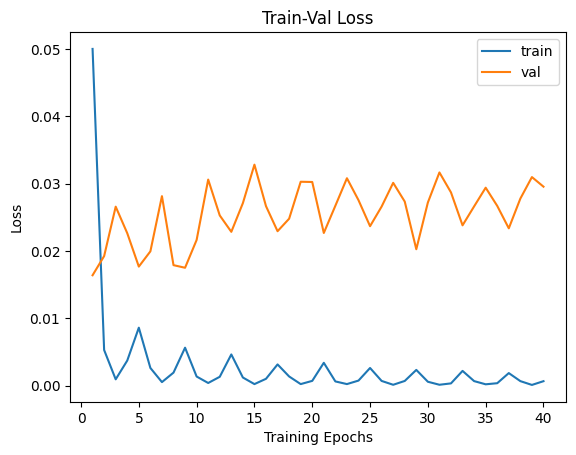

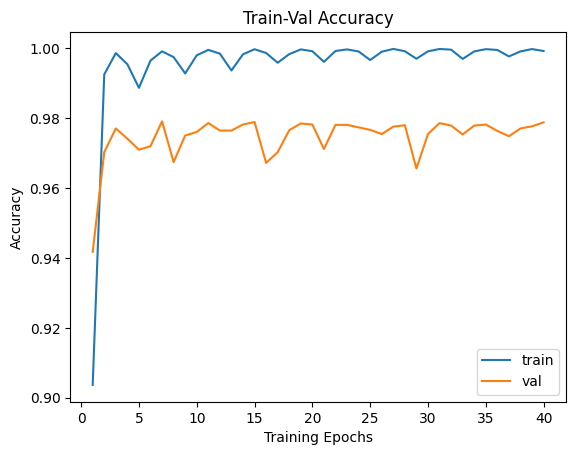

In [66]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [81]:
densenet121_pretrained.load_state_dict(torch.load('./efficientnet_b7_pretrained_expt1(upsample).pt', map_location =torch.device('cuda')))

<All keys matched successfully>

In [82]:
densenet121_pretrained.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [83]:
def deploy_model(model,dataset,device,num_classes=2):
  len_data=len(dataset)
  y_out=torch.zeros(len_data,num_classes)
  y_gt=np.zeros((len_data),dtype="uint8")
  with torch.no_grad():
    for i in range(len_data):
      x,y=dataset[i]
      y_gt[i]=y
      yy=model(x.unsqueeze(0).to(device))
      y_out[i]=torch.softmax(yy,dim=1)
  return y_out.numpy(),y_gt

In [84]:
y_out,y_gt=deploy_model(densenet121_pretrained,test_ds,device=device)

In [86]:
unique, counts = np.unique(y_gt, return_counts=True)
dict(zip(unique, counts))

{0: 1072, 1: 23}

In [87]:
y_pred = np.argmax(y_out,axis=1)

In [88]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [89]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{0: 1039, 1: 56}

In [90]:
len(test_ds)

1095

In [76]:
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_gt, y_pred),5))
print('Precision:', np.round(metrics.precision_score(y_gt, y_pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(y_gt,y_pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(y_gt, y_pred, average='weighted'),5))

Accuracy: 0.93699
Precision: 0.96391
Recall: 0.93699
F1 Score: 0.94965


In [91]:
target=['0','1']
print('\t\tClassification Report:\n', metrics.classification_report(y_gt, y_pred,target_names=target))

		Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97      1072
           1       0.09      0.22      0.13        23

    accuracy                           0.94      1095
   macro avg       0.54      0.58      0.55      1095
weighted avg       0.96      0.94      0.95      1095



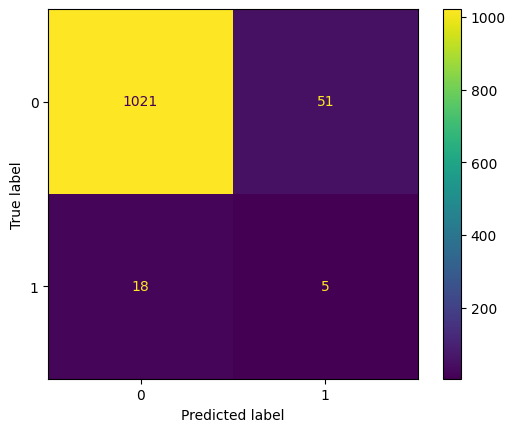

: 

In [92]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_gt, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp.plot()
plt.show()

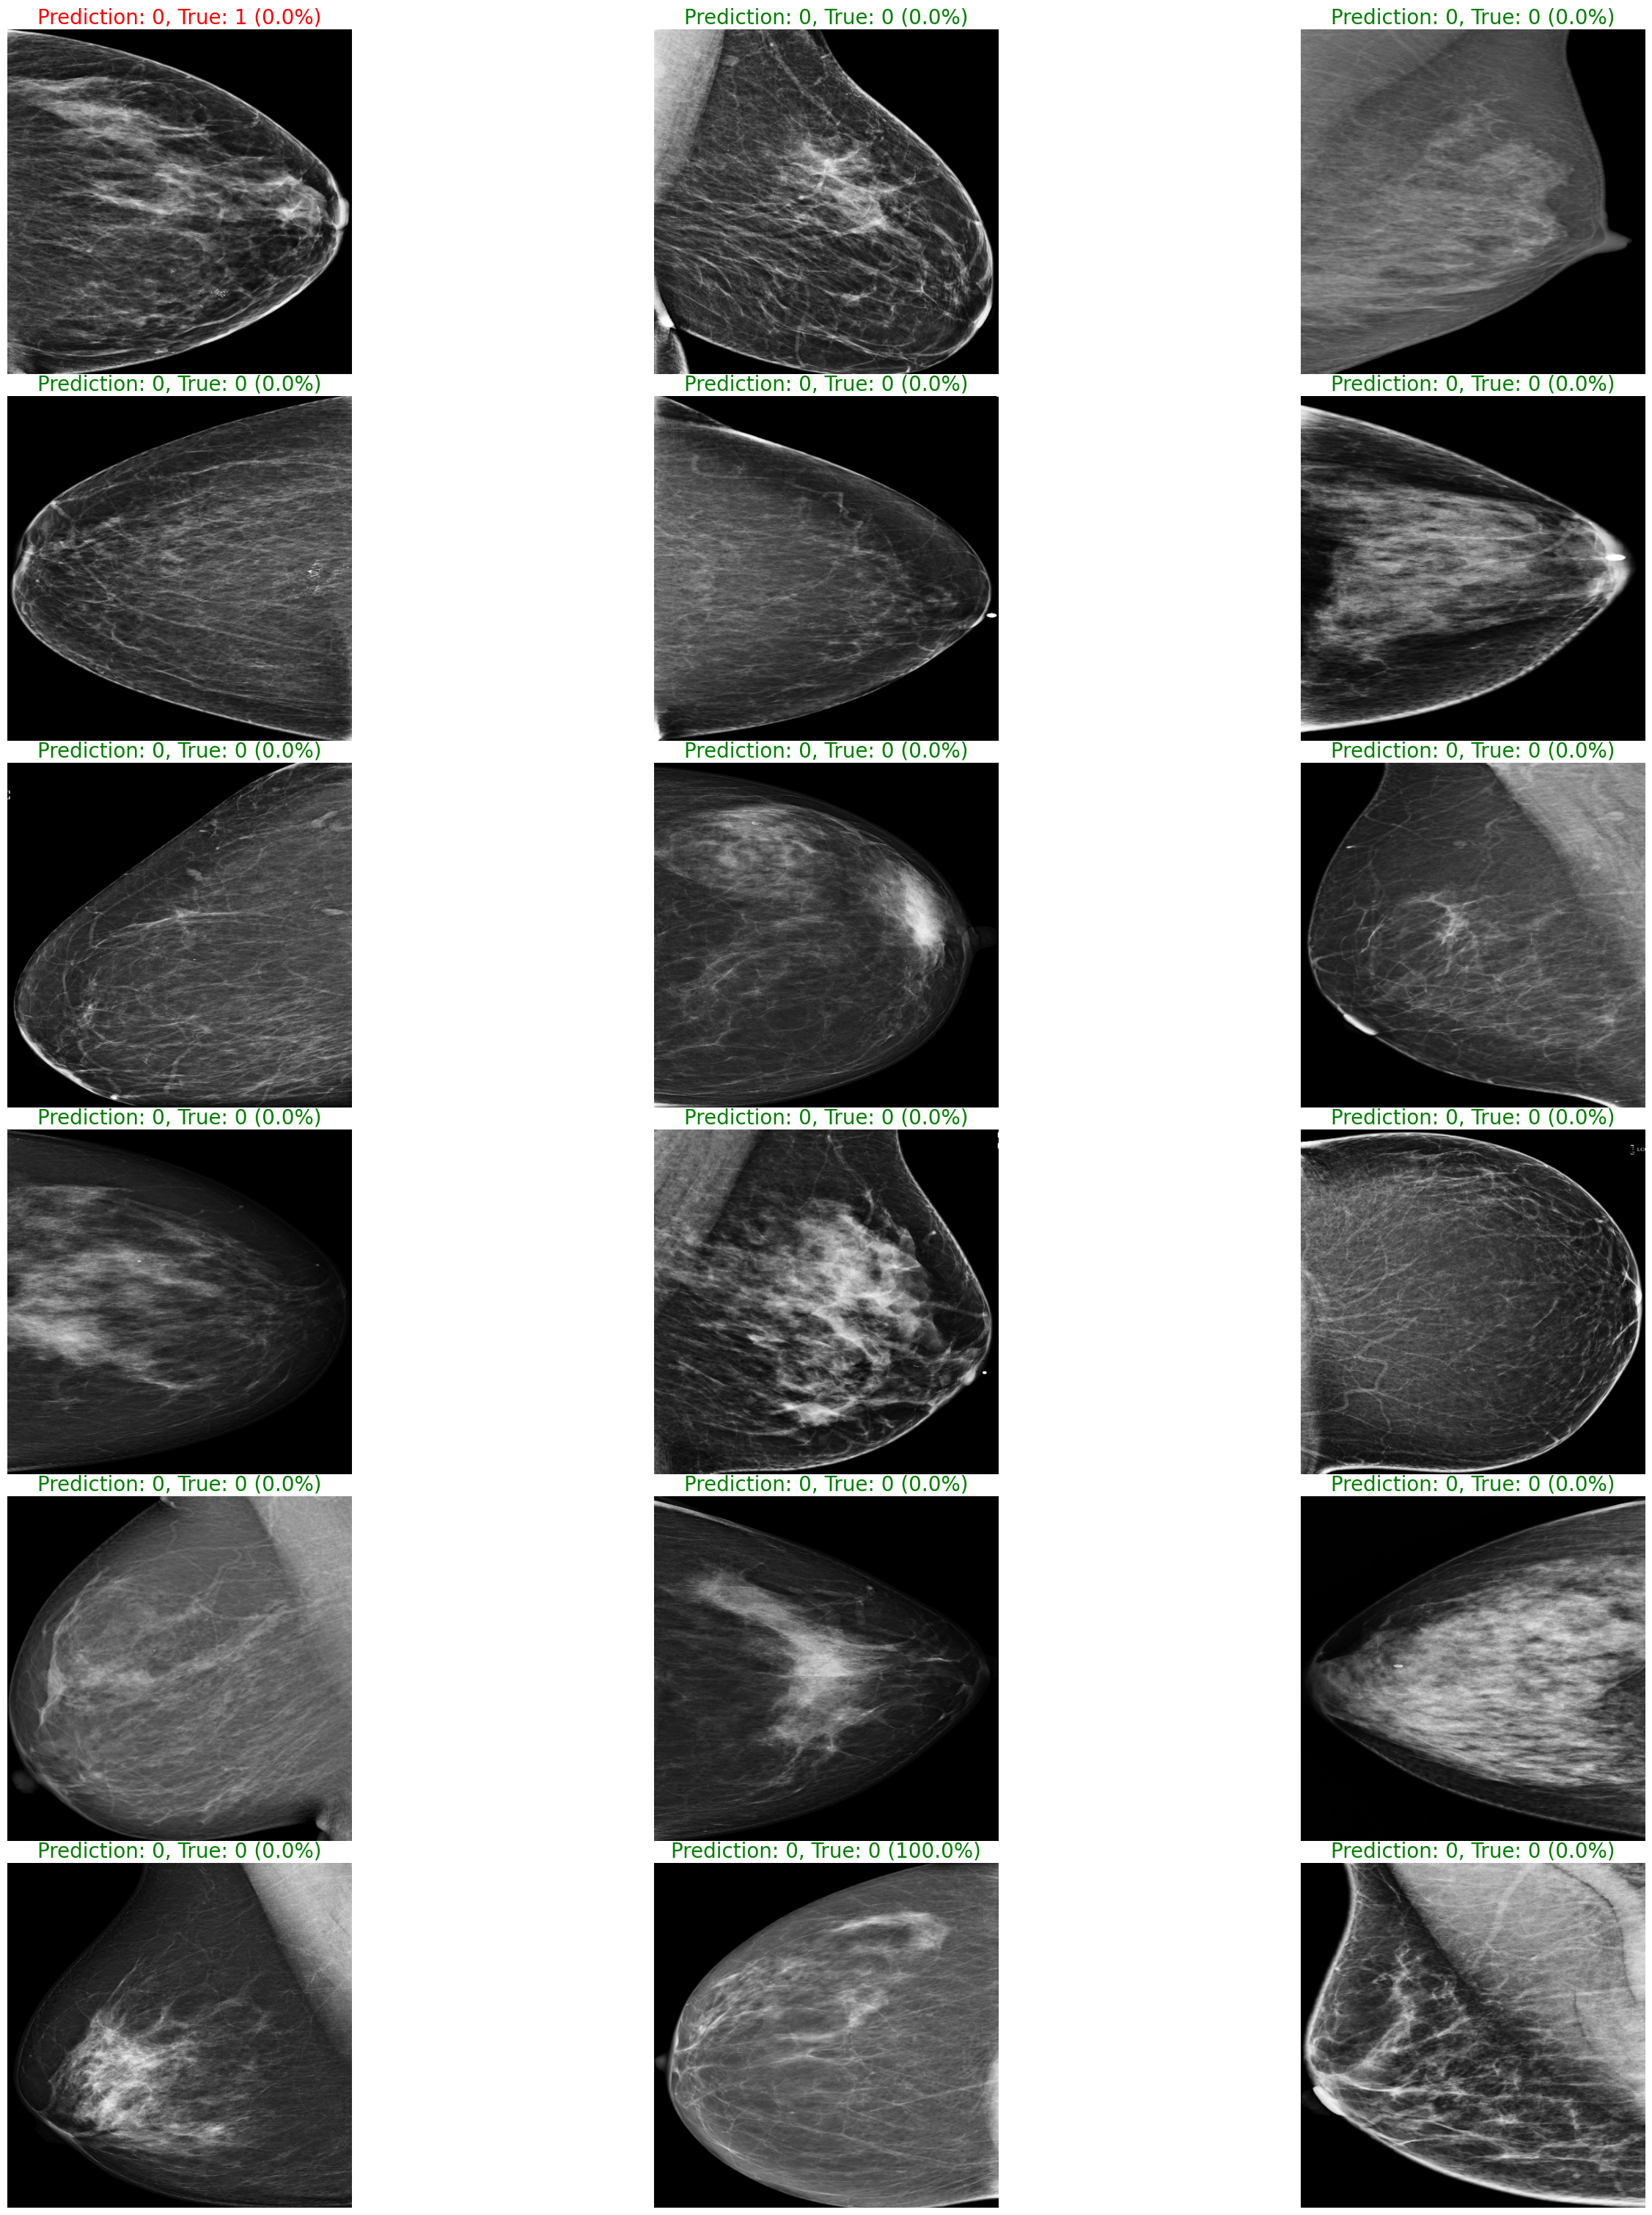

In [79]:
np.random.seed(123)
n_rows=6
n_cols=3
indices = np.random.choice(range(len(test_ds)), n_rows*n_cols, 
                            replace=False)
fig= plt.figure(figsize=(30,30))
for i, ind in enumerate(indices):
    fig.add_subplot(n_rows, n_cols, i+1)
    plt.imshow(test_ds[ind][0].numpy().transpose(1,2,0),cmap='gray')
    plt.axis('off')
    proba = y_pred[ind].max()
    pred = y_pred[ind].argmax()
    if pred == y_gt[ind]:
        colour = 'green'
    else:
        colour = 'red'
    plt.title(f"Prediction: {pred}, True: {test_ds[ind][1]} ({proba:.1%})", fontsize=20, 
              color=colour)
    #plt.subplots_adjust(wspace=0, hspace=0)
#plt.suptitle(f'Sample {dataset} images with prediction', fontsize=20)
plt.tight_layout(pad=0)

Grad-Cam

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, model):
        super(DenseNet, self).__init__()
        
        # get the pretrained DenseNet201 network
        self.densenet = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features
        
        # add the average global pool
        self.global_avg_pool = nn.AvgPool2d(kernel_size=16, stride=1)
        
        # get the classifier of the vgg19
        self.classifier = self.densenet.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        print(x.shape)
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # don't forget the pooling
        x = self.global_avg_pool(x)
        x = x.ravel()
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [ ]:
grad = DenseNet(densenet121_pretrained)
grad.eval()
img = torch.unsqueeze(test_ds[1][0].cuda(), dim=0)
pred = grad(img)

torch.Size([1, 1024, 16, 16])


In [ ]:
pred[1].backward()
gradients = grad.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = grad.get_activations(img).detach()

In [ ]:
activations.shape

torch.Size([1, 1024, 16, 16])

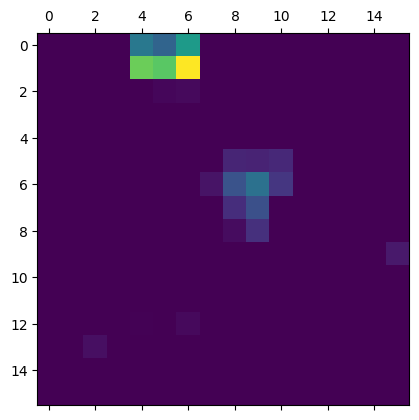

In [ ]:
for i in range(1024):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = torch.maximum(heatmap, torch.tensor([0]).cuda())

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.cpu().squeeze().numpy())

In [ ]:
import cv2
img = test_ds[1][0].numpy().transpose((1,2,0))
heatmap = cv2.resize(heatmap.cpu().numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)

True

(512, 512, 3)


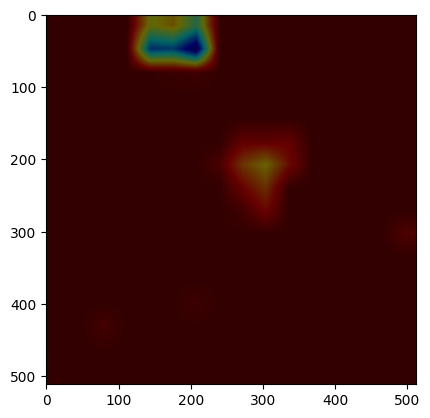

In [ ]:
a = superimposed_img.astype(np.int32)
print(a.shape)
plt.imshow(a)

0


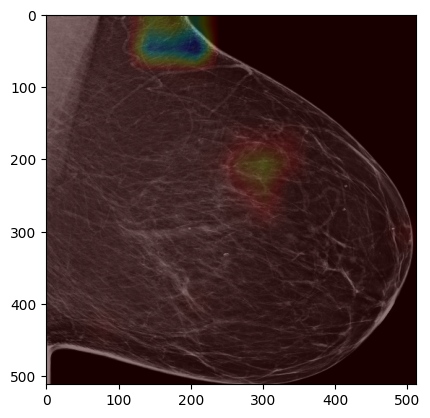

In [ ]:
plt.imshow(test_ds[1][0].permute(1,2,0).numpy())
plt.imshow(a, cmap='jet', alpha=0.5)
print(test_ds[1][1])

In [ ]:
for i in range(len(test_ds)):
    if test_ds[i][1] ==1 and y_pred[i]==1:
        print(i)

110
186
263
410
429
783


In [ ]:
# np.random.seed(123)
n_rows=6
n_cols=3
# indices = np.random.choice(range(len(test_ds)), n_rows*n_cols, 
                            # replace=False)
fig= plt.figure(figsize=(30,30))
for i, ind in enumerate(indices):
    fig.add_subplot(n_rows, n_cols, i+1)
    plt.imshow(test_ds[ind][0].numpy().transpose(1,2,0),cmap='gray')
    plt.axis('off')
    proba = y_pred[ind].max()
    pred = y_pred[ind].argmax()
    if pred == y_gt[ind]:
        colour = 'green'
    else:
        colour = 'red'
    plt.title(f"Prediction: {pred}, True: {test_ds[ind][1]} ({proba:.1%})", fontsize=20, 
              color=colour)
    #plt.subplots_adjust(wspace=0, hspace=0)
#plt.suptitle(f'Sample {dataset} images with prediction', fontsize=20)
plt.tight_layout(pad=0)

torch.Size([1, 1024, 16, 16])
torch.Size([1, 1024, 16, 16])
torch.Size([1, 1024, 16, 16])
torch.Size([1, 1024, 16, 16])
torch.Size([1, 1024, 16, 16])
torch.Size([1, 1024, 16, 16])


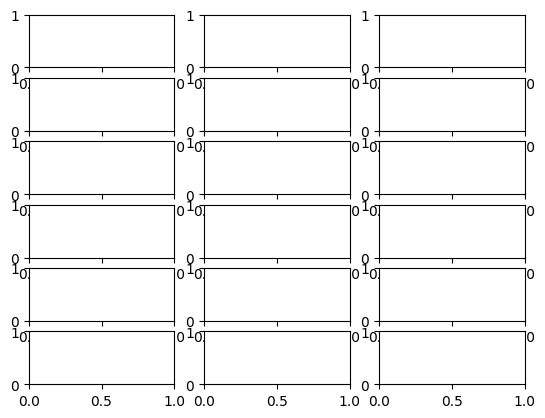

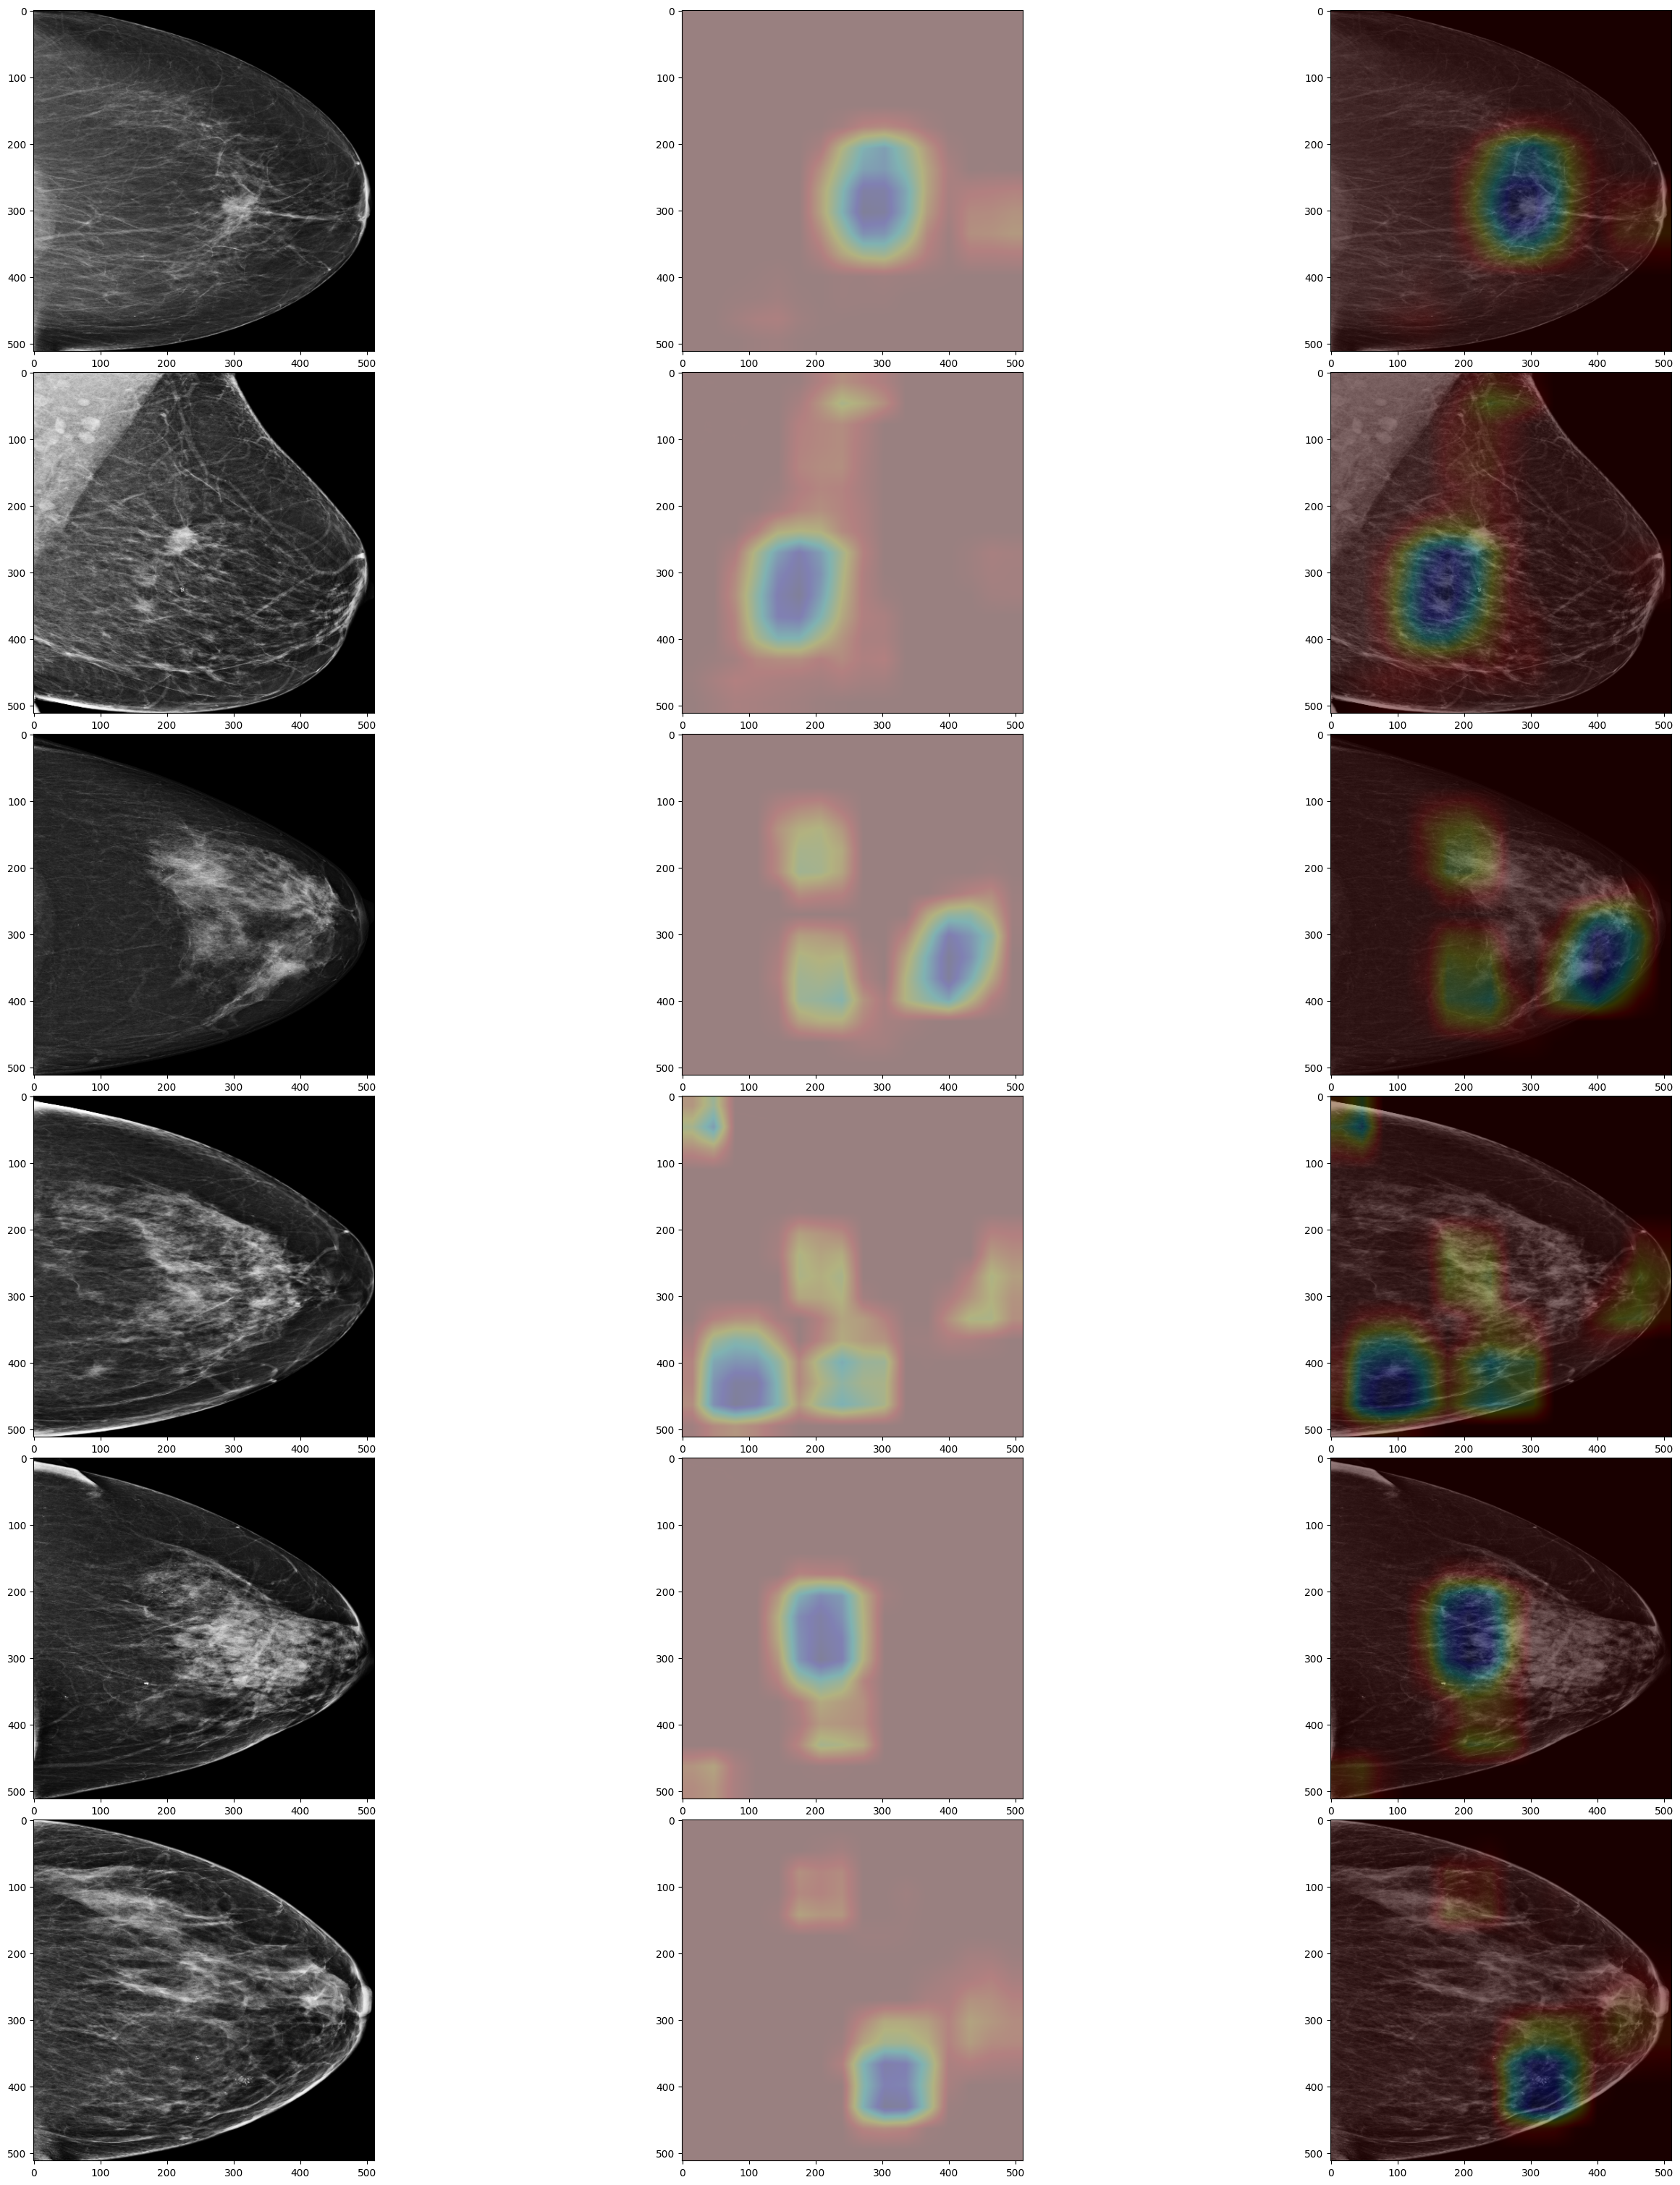

In [ ]:
import cv2

i = [110,186,263,410,429, 783]

figure, axis = plt.subplots(6,3)
k=0
fig= plt.figure(figsize=(30,30))

for j in i:
    grad = DenseNet(densenet121_pretrained)
    grad.eval()
    img = torch.unsqueeze(test_ds[j][0].cuda(), dim=0)
    pred = grad(img)
    pred[1].backward()
    gradients = grad.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = grad.get_activations(img).detach()

    for i in range(1024):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = torch.maximum(heatmap, torch.tensor([0]).cuda())

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    # plt.matshow(heatmap.cpu().squeeze().numpy())

    

    img = test_ds[j][0].numpy().transpose((1,2,0))
    heatmap = cv2.resize(heatmap.cpu().numpy(), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    # cv2.imwrite('./map_{0}.jpg', superimposed_img)
    a = superimposed_img.astype(np.int32)
    fig.add_subplot(n_rows, n_cols, k+1)
    plt.imshow(test_ds[j][0].permute(1,2,0).numpy())
    k+=1

    fig.add_subplot(n_rows, n_cols, k+1)
    plt.imshow(a, cmap='jet', alpha=0.5)
    k+=1

    fig.add_subplot(n_rows, n_cols, k+1)
    plt.imshow(test_ds[j][0].permute(1,2,0).numpy())
    plt.imshow(a, cmap='jet', alpha=0.5)
    k+=1



plt.tight_layout(pad=0)